In [32]:
import pyspark
import numpy
import pandas

from pyspark.ml.classification import LogisticRegression
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, date_format, stddev, log
from pyspark.sql.functions import min, max, to_date, udf
from pyspark.sql.functions import round, count, sum, when, lit
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import DoubleType

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder.appName("DataProcessingApp") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [33]:
df_new = spark.read.csv("encoded.csv", header=True, inferSchema=True)
row_count = df_new.count()
column_count = len(df_new.columns)

print(f"Row Count: {row_count}")
print(f"Column Count: {column_count}")

Row Count: 420212
Column Count: 23


In [34]:
# drop_col = ['Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas']
drop_col = []

df_test = df_new.drop(*drop_col)

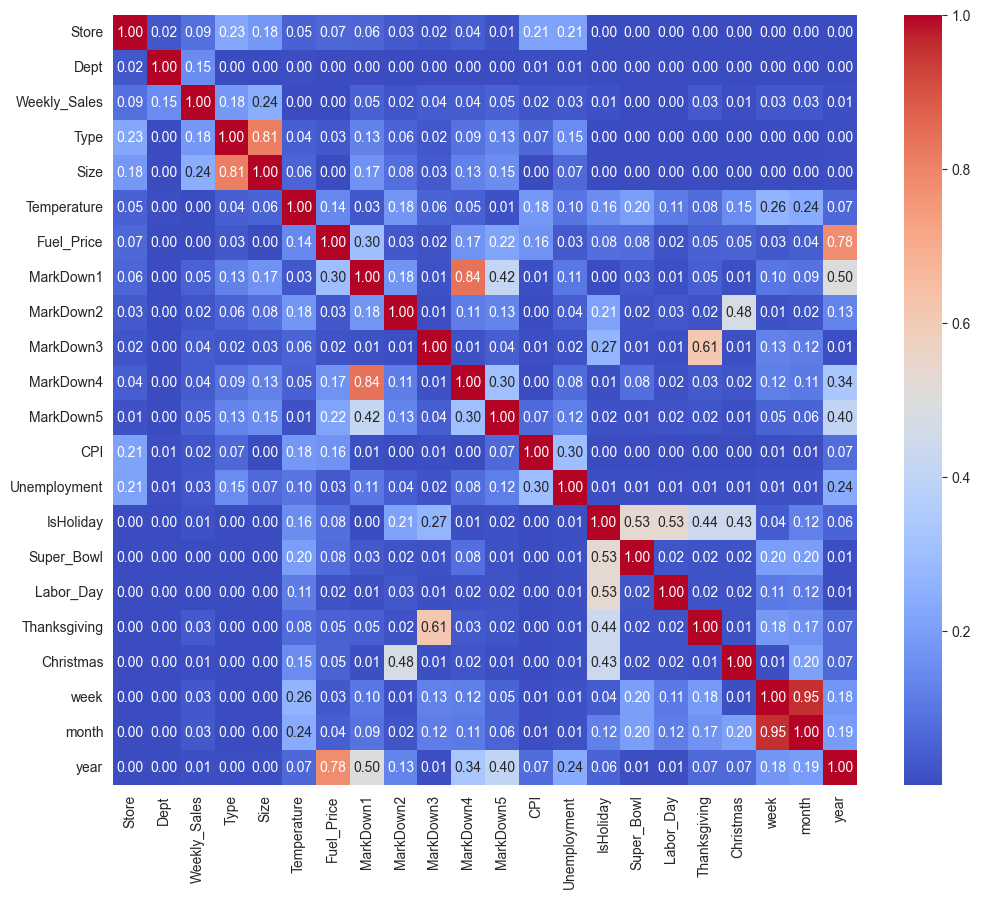

In [35]:
df_test = df_test.toPandas()
plt.figure(figsize = (12,10))
sns.heatmap(df_test.corr().abs(), annot=True, cmap='coolwarm', fmt=".2f")    # To see the correlations
plt.show()

'Super_Bowl', 'Labor_Day', 'Fuel_Price', 'Temperature' have no significant effect on weekly sales, so I will drop them. Also, Markdown 4 and 5 highly correlated with Markdown 1. So, I will drop them also. It can create multicollinearity problem, maybe. So, first I will try without them.

In [36]:
drop_col = ['Super_Bowl', 'Labor_Day', 'Fuel_Price', 'Temperature', 'MarkDown4', 'MarkDown3', 'Month', 'Type']
# drop_col = []

df_test = df_new.drop(*drop_col)

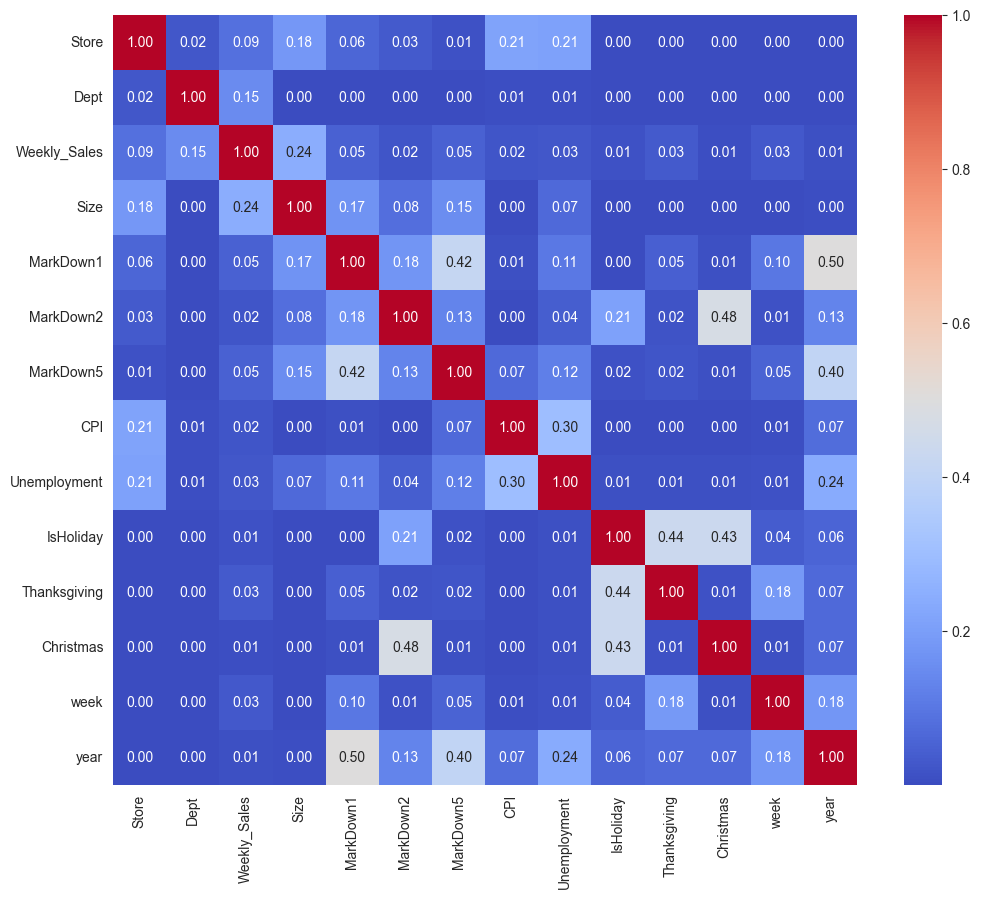

In [37]:
df_show = df_test.toPandas()
plt.figure(figsize = (12,10))
sns.heatmap(df_show.corr().abs(), annot=True, cmap='coolwarm', fmt=".2f")    # To see the correlations
plt.show()

In [38]:
df_test = df_test.withColumn("CPI_log", log(col("CPI")))
df_test = df_test.withColumn("Unemployment_log", log(col("Unemployment")))


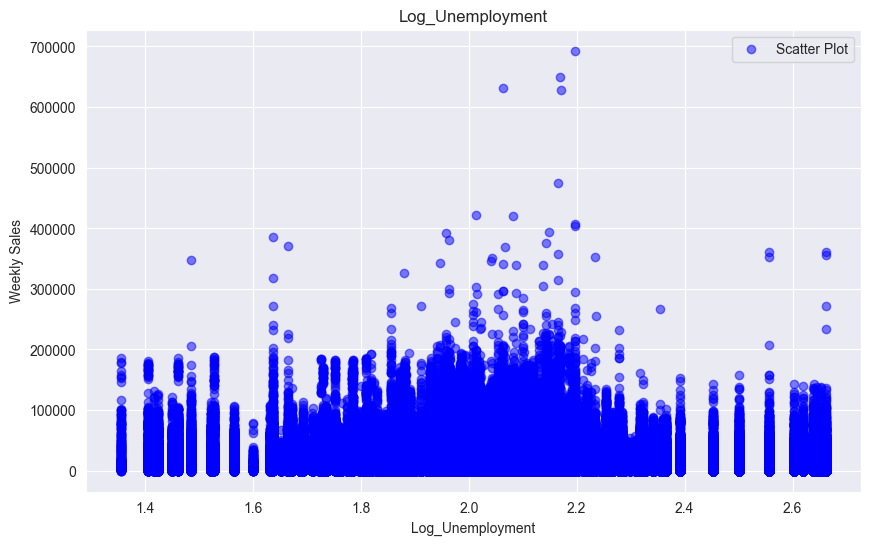

In [39]:
df_show = df_test.toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(df_show['Unemployment_log'], df_show['Weekly_Sales'], alpha=0.5, label='Scatter Plot', color='blue')
plt.xlabel('Log_Unemployment')
plt.ylabel('Weekly Sales')
plt.title('Log_Unemployment')
plt.legend()
plt.grid(True)
plt.show()

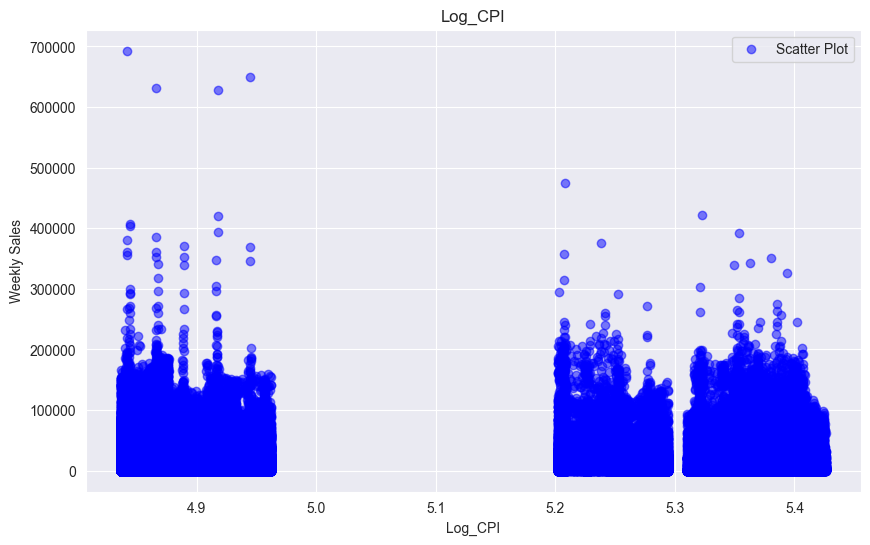

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(df_show['CPI_log'], df_show['Weekly_Sales'], alpha=0.5, label='Scatter Plot', color='blue')
plt.xlabel('Log_CPI')
plt.ylabel('Weekly Sales')
plt.title('Log_CPI')
plt.legend()
plt.grid(True)
plt.show()

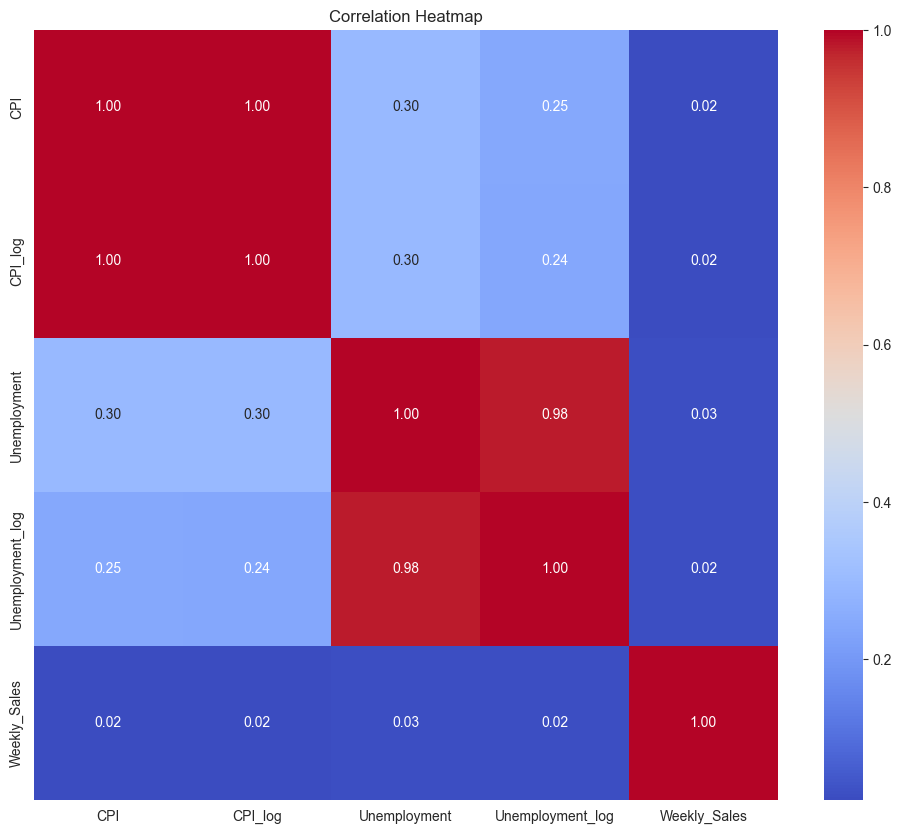

In [41]:
# 选择感兴趣的列
columns_of_interest = ["CPI", "CPI_log", "Unemployment", "Unemployment_log", "Weekly_Sales"]
df_show = df_test.select(columns_of_interest)
df_show =df_show.toPandas()

# 创建热力图
plt.figure(figsize=(12, 10))
sns.heatmap(df_show.corr().abs(), annot=True, cmap='coolwarm', fmt=".2f")  # To see the correlations
plt.title("Correlation Heatmap")
plt.show()

In [42]:
drop_col = ['CPI', 'Unemployment_log']
# drop_col = []

df_test = df_test.drop(*drop_col)

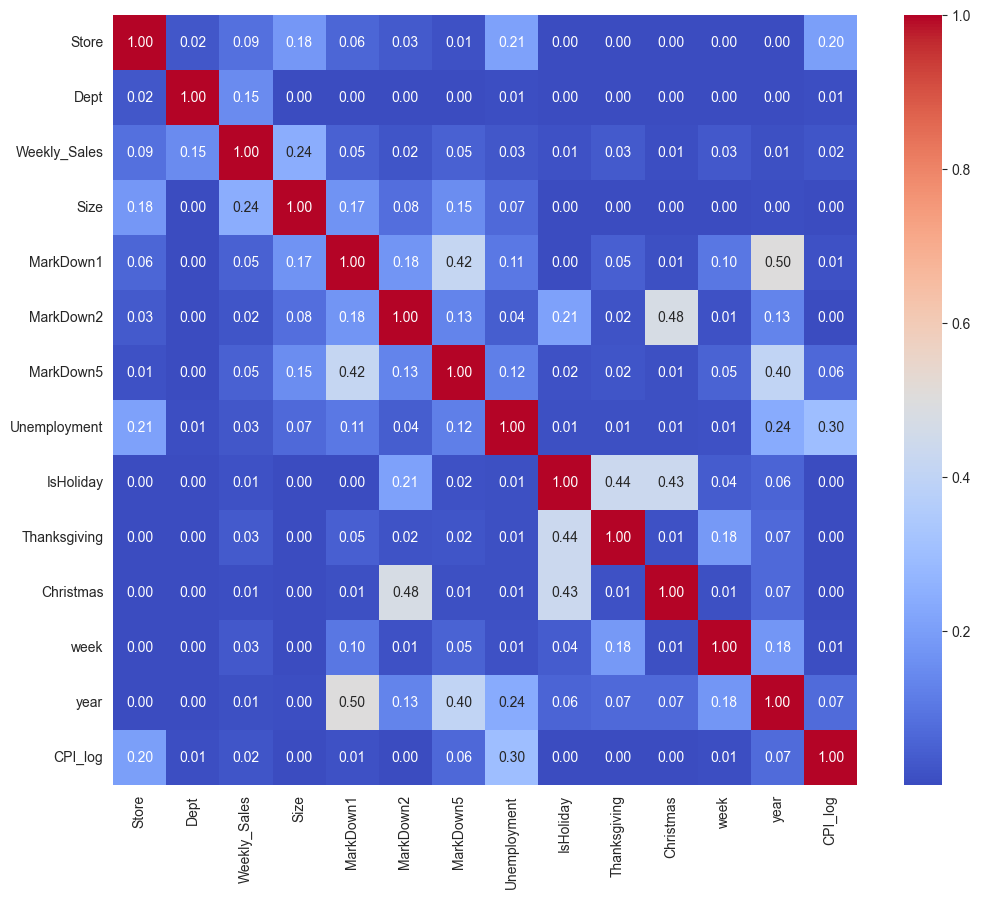

In [43]:
df_show = df_test.toPandas()
plt.figure(figsize = (12,10))
sns.heatmap(df_show.corr().abs(), annot=True, cmap='coolwarm', fmt=".2f")    # To see the correlations
plt.show()

# Creating Train-Test Splits

In [44]:
SPARK_FLAG = False
if SPARK_FLAG:

    total_rows = df_test.count()

    train_ratio = 0.7
    train_data = df_test.limit(int(total_rows * train_ratio))
    test_data = df_test.subtract(train_data)

    target = "Weekly_Sales"
    used_cols = [c for c in df_test.columns if c != target]

    X_train = train_data.select(*used_cols)
    X_test = test_data.select(*used_cols)
    y_train = train_data.select(target)
    y_test = test_data.select(target)

    X = df_test.select(*used_cols)

    X_train = X_train.drop("Date")
    X_test = X_test.drop("Date")

In [45]:
df_new = df_test.toPandas()
train_data = df_new[:int(0.7 * (len(df_new)))]  # taking train part
test_data = df_new[int(0.7 * (len(df_new))):]  # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]]  # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]
X = df_new[used_cols]  # to keep train and test X values together

In [46]:
X = df_new[used_cols] # to keep train and test X values together

In [47]:
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

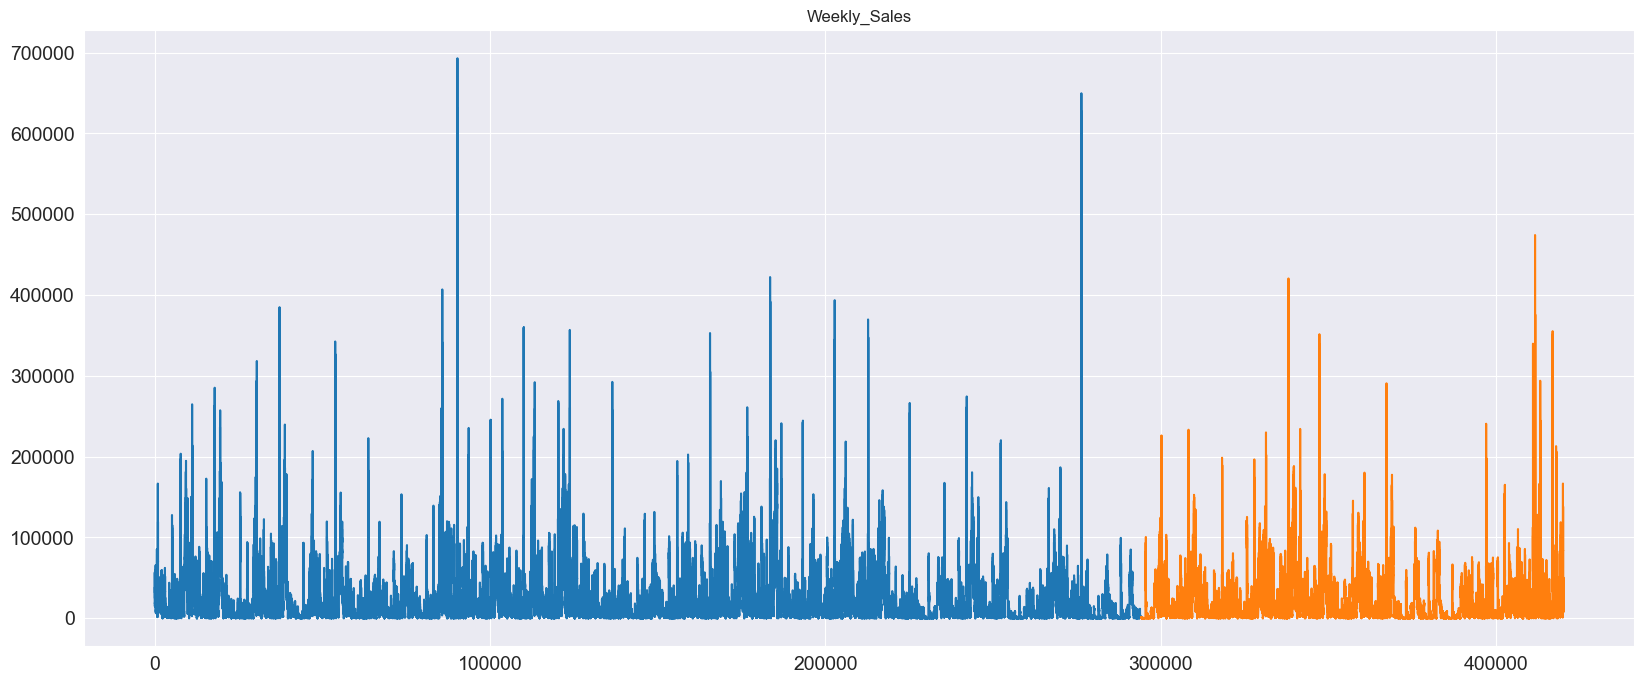

In [48]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

In [49]:
def wmae_test_spark(test, pred):
    test_data = X_test.withColumn("test", F.col(test))
    test_data = test_data.withColumn("pred", F.col(pred))

    test_data = test_data.withColumn("weights", F.when(F.col("IsHoliday") == True, 5).otherwise(1))

    error = test_data.select(
        (F.sum(F.col("weights") * F.abs(F.col("test") - F.col("pred"))).alias("error")),
        (F.sum(F.col("weights")).alias("total_weights"))
    ).first()

    wmae = error.error / error.total_weights
    return wmae

In [50]:
def wmae_test(test, pred): # WMAE for test
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = numpy.sum(weights * numpy.abs(test - pred), axis=0) / numpy.sum(weights)
    return error

# Random Forest Regressor

In [51]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler

In [52]:
spark_flag = False

if spark_flag:

    feature_cols = ["CPI", "Unemployment", "Temperature"]

    vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df = vector_assembler.transform(df_test)

    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
    scaler_model = scaler.fit(df)
    df = scaler_model.transform(df)

    rf = RandomForestRegressor(numTrees=50, seed=42, maxDepth=35, featureSubsetStrategy="sqrt", minInstancesPerNode=10)

    pipeline = Pipeline(stages=[rf])

    model = pipeline.fit(df)

    y_pred_train = model.transform(df)

    test_data = [(6, 900, 2.45, 7.3)]
    test_df = spark.createDataFrame(test_data, ["Store", "CPI", "Unemployment", "Temperature"])
    test_df = vector_assembler.transform(test_df)
    test_df = scaler_model.transform(test_df)

    y_pred_test = model.transform(test_df)

    y_pred_train.show()
    y_pred_test.show()


In [53]:
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)
scaler = RobustScaler()

# making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler, rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

print(y_pred)
print(y_pred_test)

[29943.25556289 35980.19071378 29881.63210952 ...  1313.91183378
  1136.87000357  1322.99798144]
[ 2035.59016169  1732.85554933  1494.45303091 ... 12380.42386356
 12847.08347103 18464.87850507]


In [55]:
wmae_test(y_test, y_pred_test)

8146.722904282491

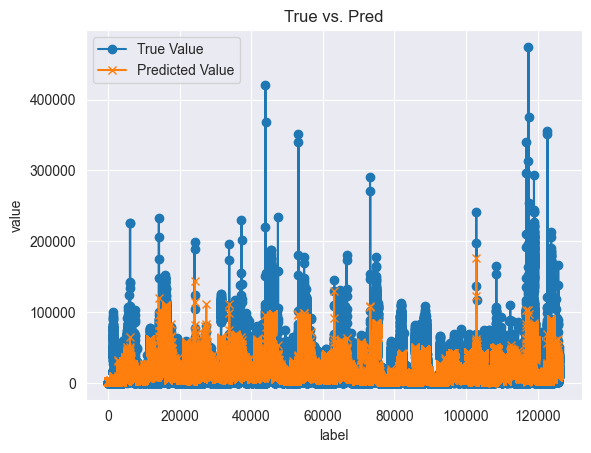

In [56]:
x = range(len(y_test))

plt.plot(x, y_test, label='True Value', marker='o')
plt.plot(x, y_pred_test, label='Predicted Value', marker='x')
plt.legend()
plt.xlabel('label')
plt.ylabel('value')
plt.title('True vs. Pred')
plt.show()

In [57]:
if spark_flag:

    X = X.drop("Date")
    feature_names = X.columns

    vector_assembler = VectorAssembler(inputCols=X_train.columns, outputCol="features")
    X_train = vector_assembler.transform(X_train)

    importances = model.featureImportances

    print("Feature ranking:")
    feature_names = X_train.columns
    importances_with_names = list(zip(feature_names, importances))
    importances_with_names.sort(key=lambda x: x[1], reverse=True)

    for f, (feature_name, importance) in enumerate(importances_with_names):
        print("%d. feature %s (%f)" % (f + 1, feature_name, importance))

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(len(importances_with_names)), [importance for (_, importance) in importances_with_names], color="r")
    plt.xticks(range(len(importances_with_names)), [feature_name for (feature_name, _) in importances_with_names], rotation=90)
    plt.tight_layout()
    plt.show()



In [58]:
X = X.drop(['Date'], axis=1) #dropping date column from X
feature_names = X.columns.tolist()

Feature ranking:
1. feature Dept (0.705258)
2. feature Size (0.126942)
3. feature Store (0.058569)
4. feature CPI_log (0.037502)
5. feature Unemployment (0.025204)
6. feature week (0.021832)
7. feature MarkDown5 (0.008231)
8. feature MarkDown1 (0.006426)
9. feature MarkDown2 (0.004202)
10. feature year (0.002087)
11. feature Thanksgiving (0.002003)
12. feature IsHoliday (0.001356)
13. feature Christmas (0.000388)


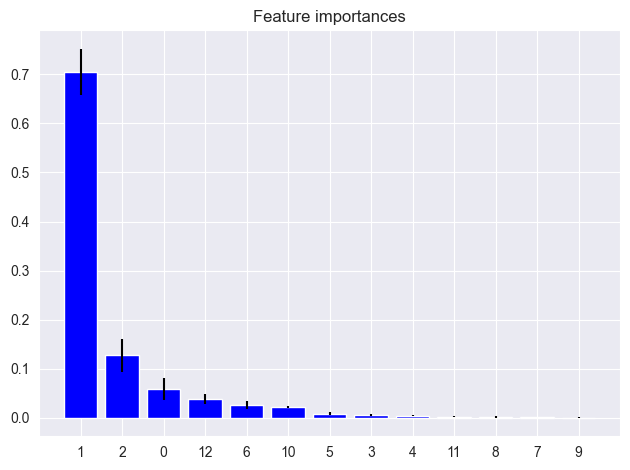

In [59]:
importances = rf.feature_importances_
std = numpy.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = numpy.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# feature_labels = [feature_names[i] for i in indices]

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="b", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

In [60]:
if SPARK_FLAG:

    from graphframes import GraphFrame
    from graphviz import Digraph

    tree_list = model.stages[-1].trees

    vertices = [(node_id, {}) for node_id in range(len(tree_list))]
    edges = [(node_id, tree.leftChild(node_id)) for node_id, tree in enumerate(tree_list) if tree.leftChild(node_id) is not None]
    edges += [(node_id, tree.rightChild(node_id)) for node_id, tree in enumerate(tree_list) if tree.rightChild(node_id) is not None]

    g = GraphFrame(spark.createDataFrame(vertices, ["id", "data"]), spark.createDataFrame(edges, ["src", "dst"]))

    for i, tree in enumerate(tree_list):
        dot = Digraph(comment=f"Decision Tree {i+1}")
        visited = set()

        def dfs(node_id):
            if node_id in visited:
                return
            visited.add(node_id)
            dot.node(str(node_id), label=f"Feature: {tree.split(node_id)}\nThreshold: {tree.threshold(node_id):.2f}\nImpurity: {tree.impurity(node_id):.2f}")

            if tree.leftChild(node_id) is not None:
                dot.edge(str(node_id), str(tree.leftChild(node_id)))
                dfs(tree.leftChild(node_id))

            if tree.rightChild(node_id) is not None:
                dot.edge(str(node_id), str(tree.rightChild(node_id)))
                dfs(tree.rightChild(node_id))

        dfs(0)
        dot.render(f"decision_tree_{i+1}")


In [65]:
V_tree = False

from sklearn.tree import plot_tree

if V_tree:
    plot_tree(rf.estimators_[0], filled=True)
    plt.title(f'Tree {1}')
    plt.show()


# Time Series Models

In [66]:
df = spark.read.csv("iteration4cleandata.csv", header=True, inferSchema=True)
row_count = df.count()
column_count = len(df.columns)

print(f"Row Count: {row_count}")
print(f"Column Count: {column_count}")

Row Count: 420212
Column Count: 23


In [67]:
df = df.toPandas()
df.head() # to see my data

,Store,Date,Dept,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,CPI,Unemployment,IsHoliday,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,2010-02-05,1,24924.50,A,151315,42.31,2.572,0.0,0.0,...,211.096358,8.106,False,False,False,False,False,6,2,2010
1,1,2010-02-12,1,46039.49,A,151315,38.51,2.548,0.0,0.0,...,211.242170,8.106,True,True,False,False,False,7,2,2010
2,1,2010-02-19,1,41595.55,A,151315,39.93,2.514,0.0,0.0,...,211.289143,8.106,False,False,False,False,False,8,2,2010
3,1,2010-02-26,1,19403.54,A,151315,46.63,2.561,0.0,0.0,...,211.319643,8.106,False,False,False,False,False,9,2,2010
4,1,2010-03-05,1,21827.90,A,151315,46.50,2.625,0.0,0.0,...,211.350143,8.106,False,False,False,False,False,10,3,2010


In [68]:
df["Date"] = pandas.to_datetime(df["Date"]) #changing data to datetime for decomposing

In [69]:
df.set_index('Date', inplace=True) #seting date as index

## Plotting Sales

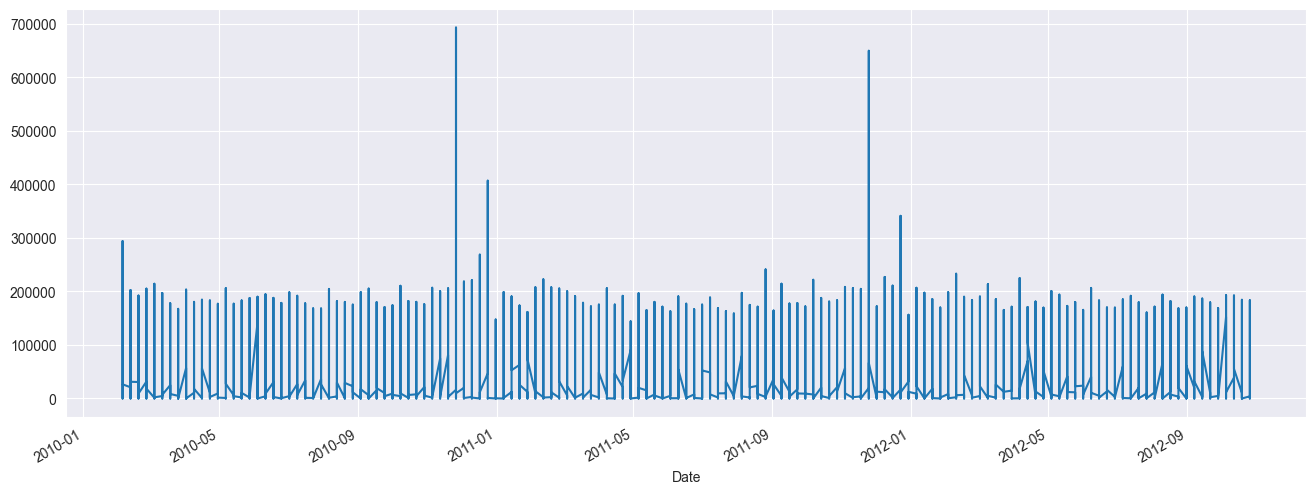

In [70]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

In this data, there are lots of same data values. So, I will collect them together as weekly.

In [71]:
df_week = df.resample('W').mean() #resample data as weekly

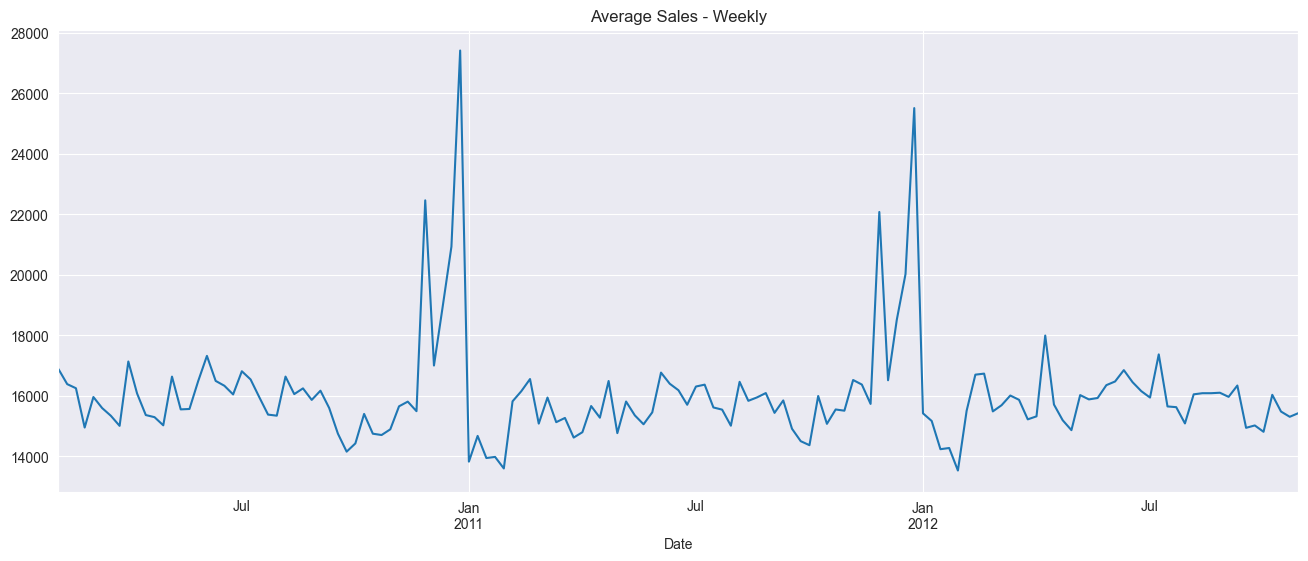

In [72]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

With the collecting data as weekly, I can see average sales clearly. To see monthly pattern , I resampled my data to monthly also.

In [73]:
df_month = df.resample('MS').mean() # resampling as monthly

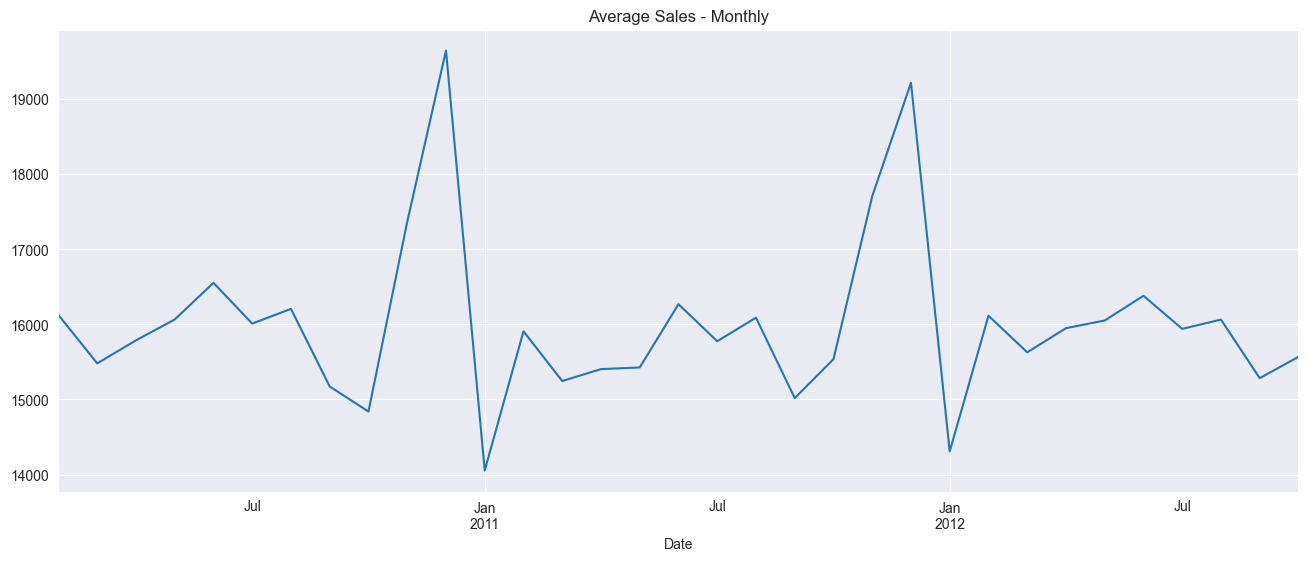

In [74]:
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

When I turned data to monthly, I realized that I lost some patterns in weekly data. So, I will continue with weekly resampled data.

## To Observe 2-weeks Rolling Mean and Std

My data is non-stationary. So, I will try to find more stationary version on it.

In [75]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

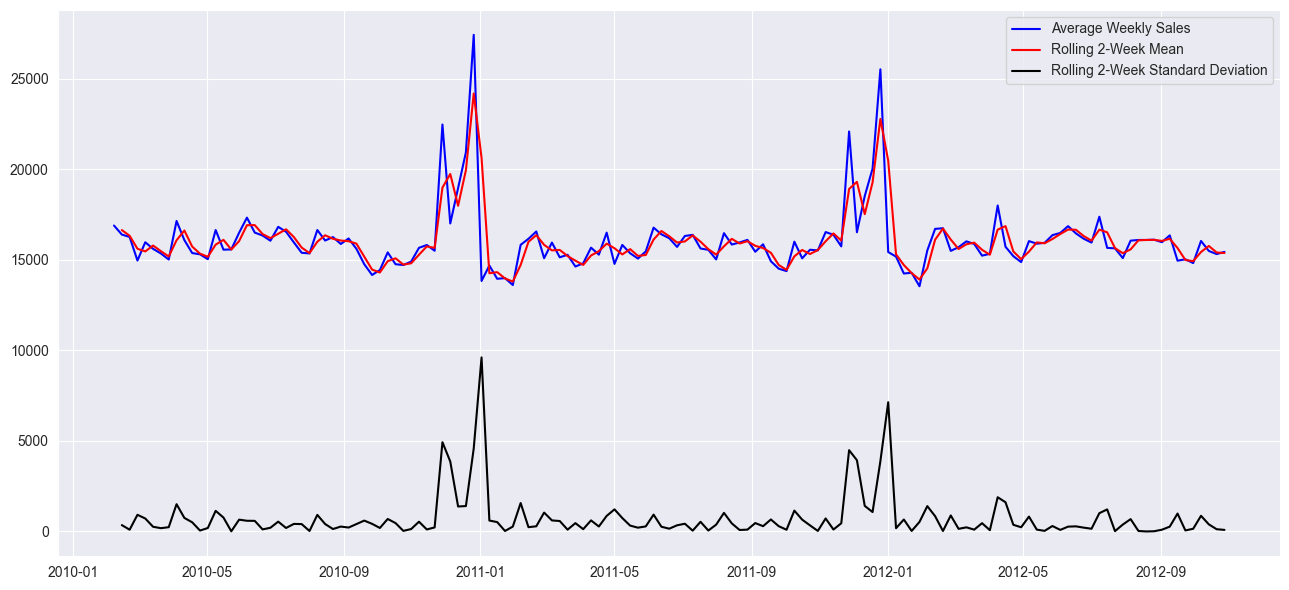

In [76]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

## Adfuller Test to Make Sure

In [77]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737569,
 2.429049208204254e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

From test and my observations my data is not stationary. So, I will try to find more stationary version of it.

## Train - Test Split of Weekly Data

In [78]:
train_data = df_week[:int(0.7*(len(df_week)))]
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 21)
Test: (43, 21)


In [79]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

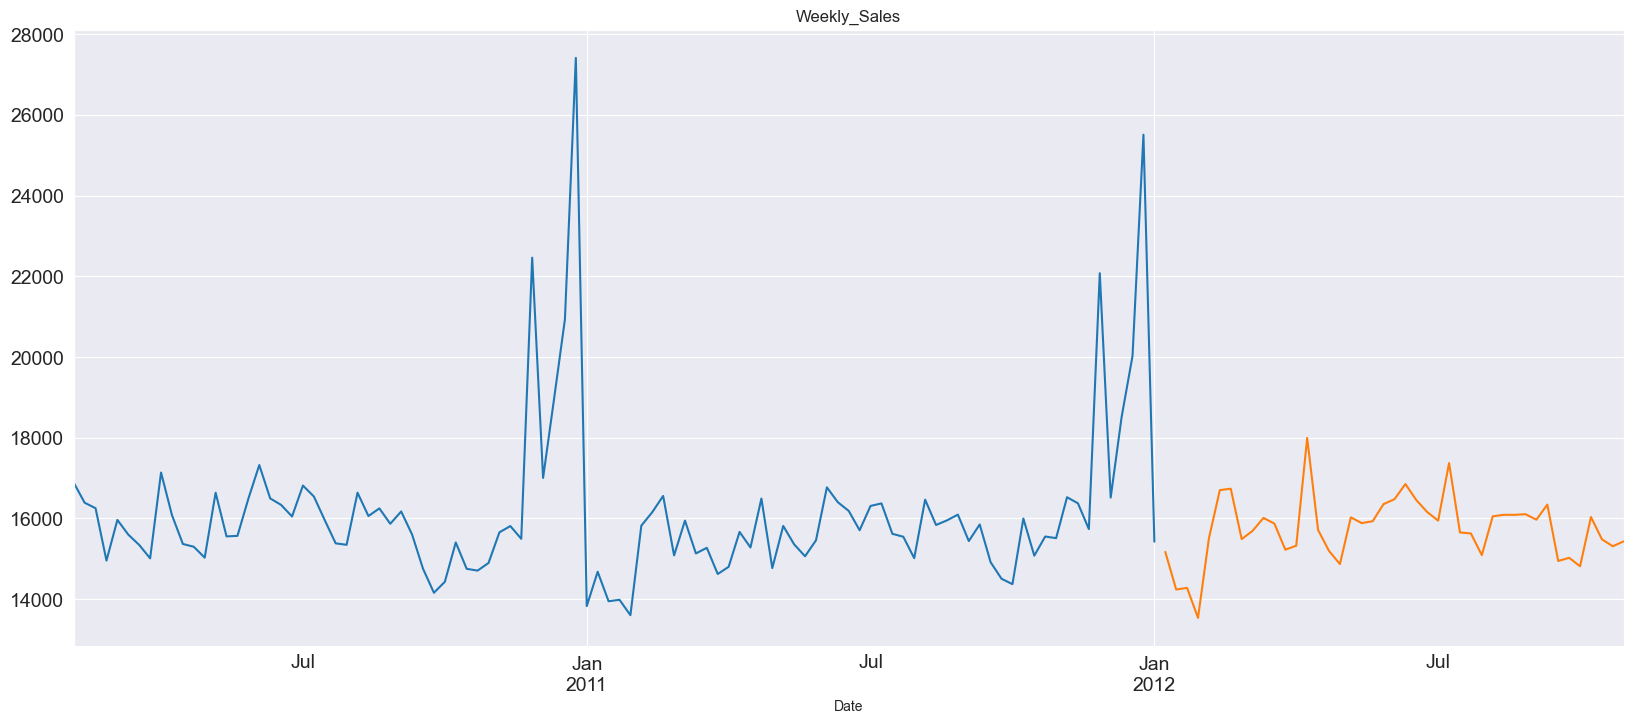

In [80]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

Blue line represents my train data, yellow is test data.

## Decomposing Weekly Data to Observe Seasonality

In [81]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20)
#decomposing of weekly data

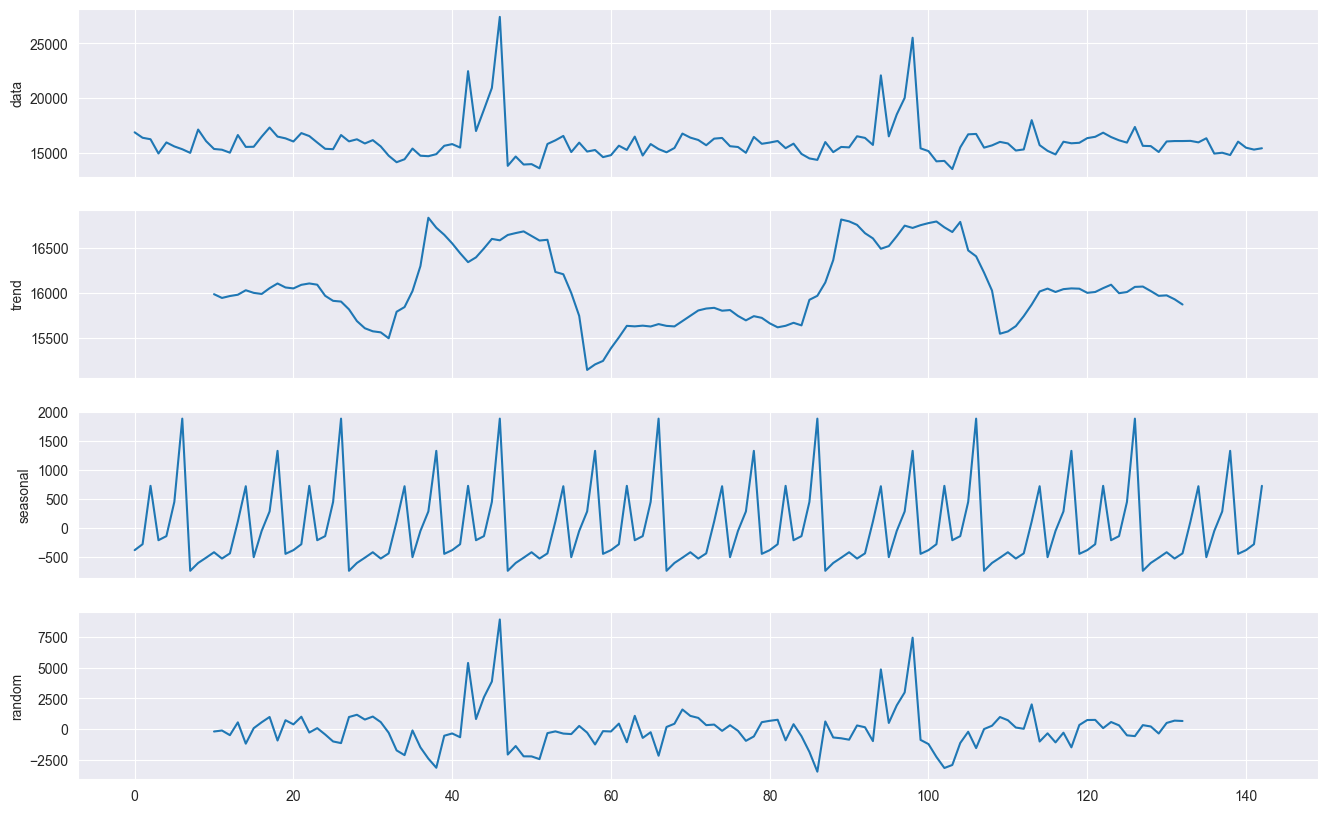

In [82]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

From the graphs above, every 20 step seasonality converges to beginning point. This helps me to tune my model.

## Trying To Make Data More Stationary

Now, I will try to make my data more stationary. To do this, I will try model with differenced, logged and shifted data.

### 1. Difference

In [83]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values

In [84]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

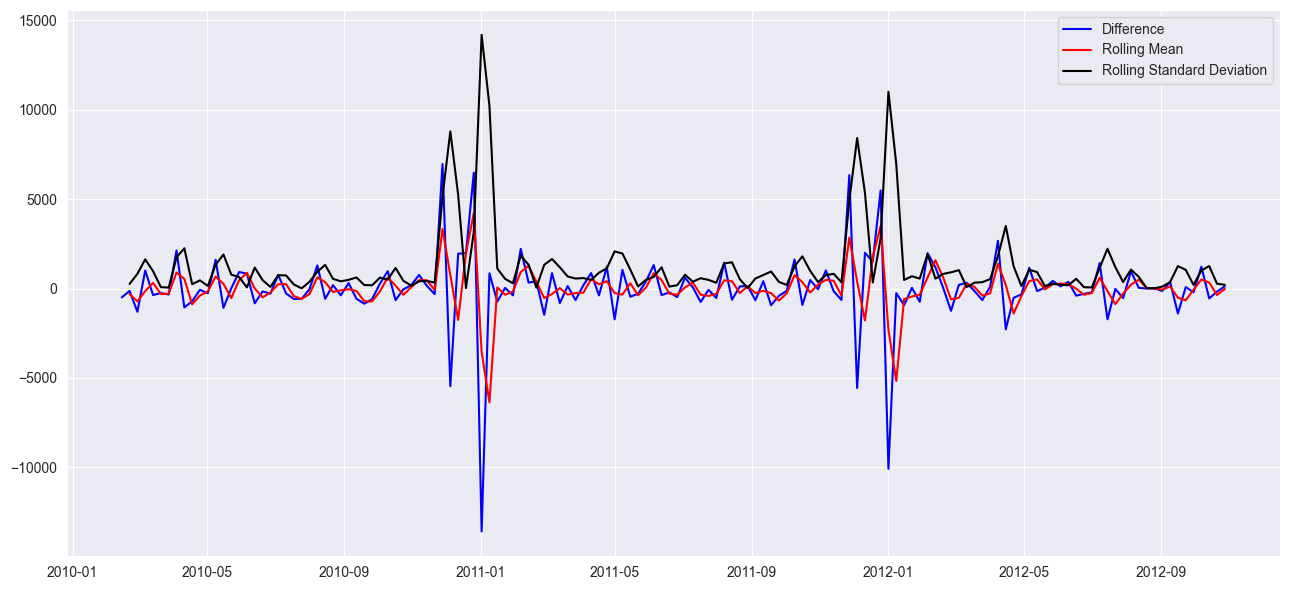

In [85]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

### 2. Shift

In [86]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna() #shifting the data

In [87]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean()
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

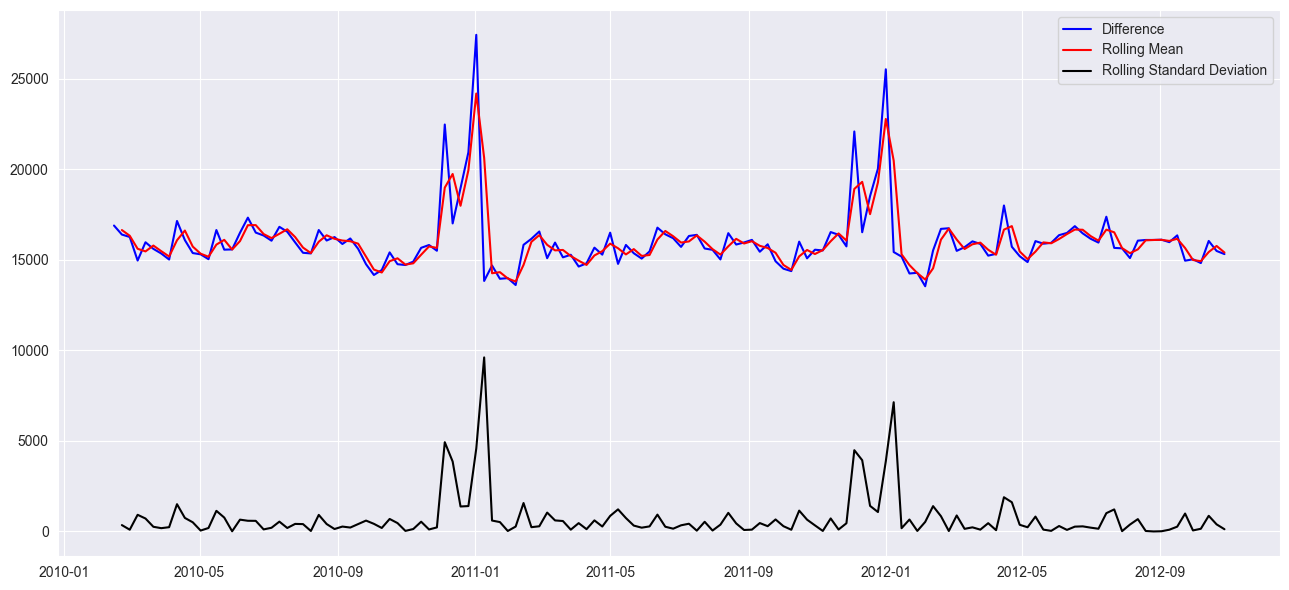

In [88]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

### 3. Log

In [89]:
logged_week = numpy.log1p(df_week['Weekly_Sales']).dropna() #taking log of data

In [90]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

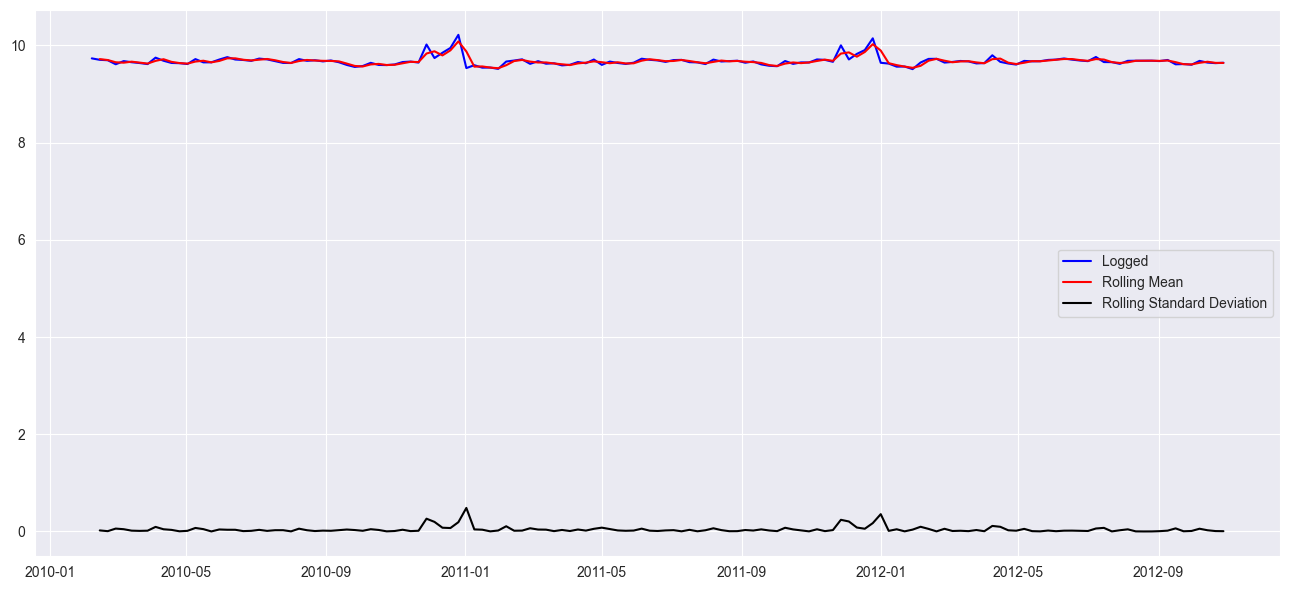

In [91]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## Auto-ARIMA MODEL

I tried my data without any changes, then tried with shifting, taking log and difference version of data. Differenced data gave best results. So, I decided to take difference and use this data.

## Train-Test Split

In [92]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [93]:
model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                              max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                              information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                              error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

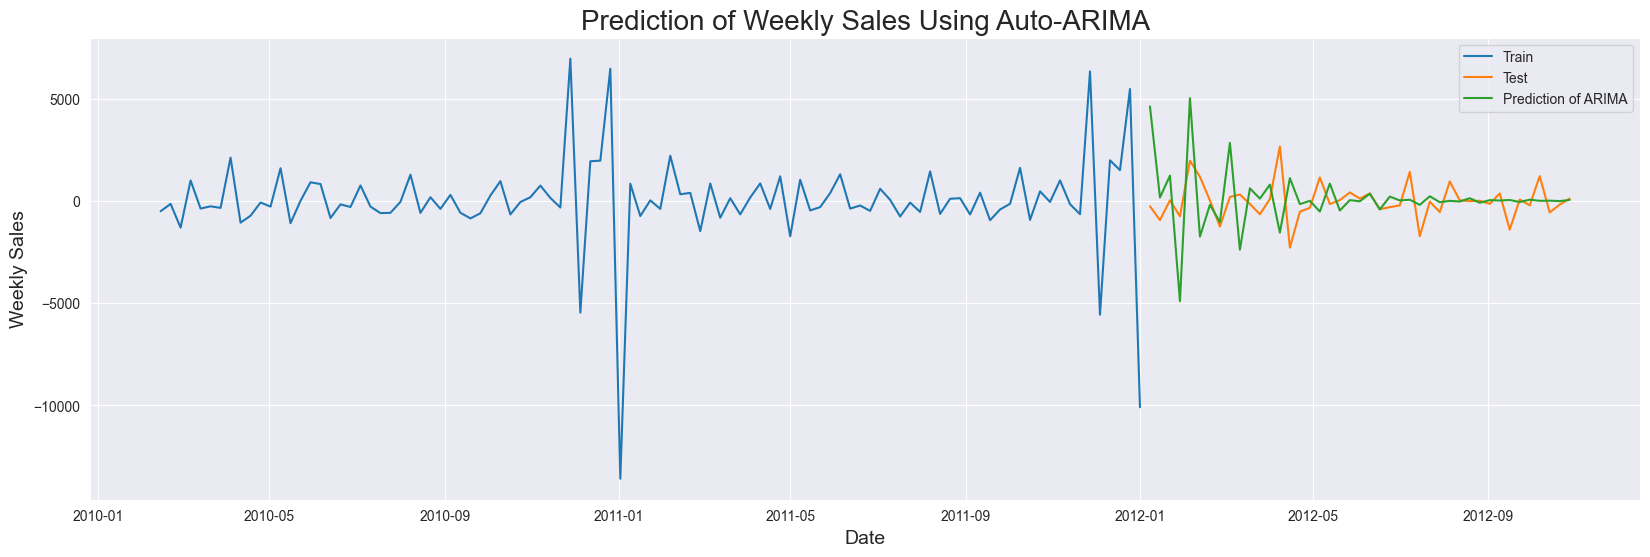

In [101]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pandas.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])

plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()



I do not like the pattern of predictions, so I decided to try another model.

## ExponentialSmoothing

I checked suitable Holt-Winters models according tp my data. Exponential Smooting are used when data has trend, and it flattens the trend. The damped trend method adds a damping parameter so, the trend converges to a constant value in the future.

My difference data has some minus and zero values, so I used additive seasonal and trend instead of multiplicative. Seasonal periods are chosen from the decomposed graphs above. For tuning the model with iterations take too much time so, I changed and tried model for different parameters and found the best parameters and fitted them to model.

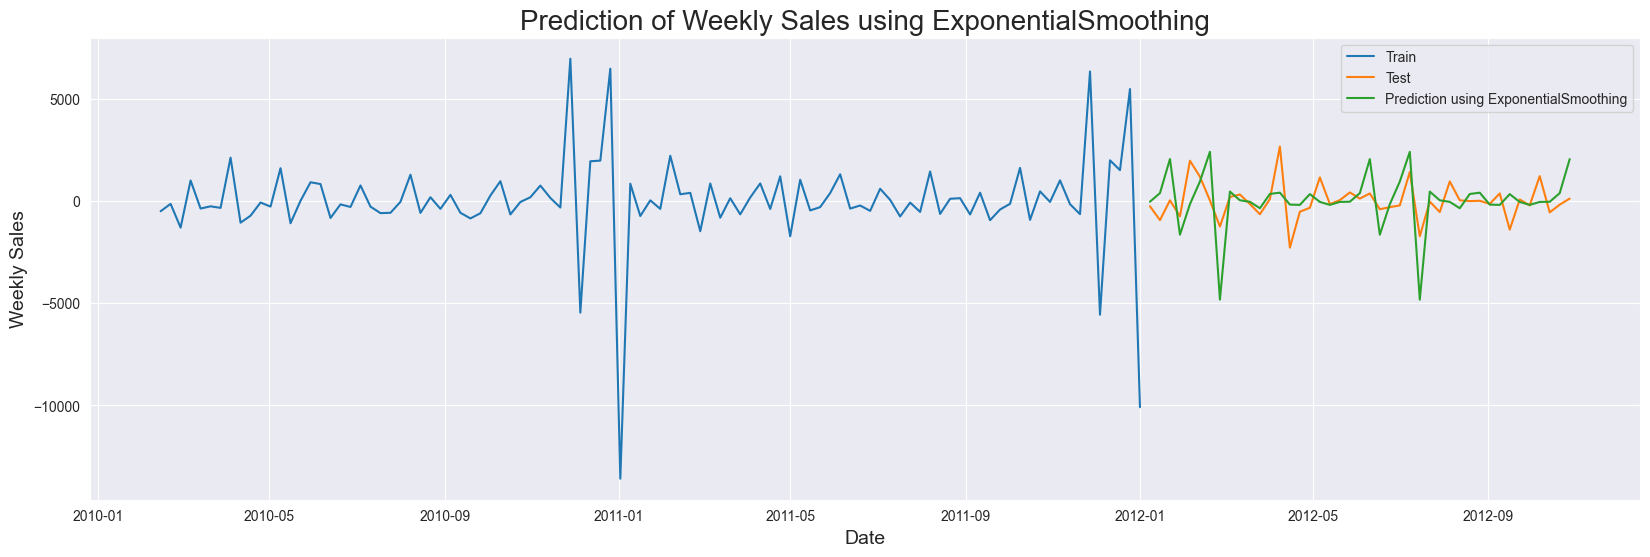

In [102]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                          trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


In [103]:
wmae_test(test_data_diff, y_pred)

840.681060966696